<a href="https://colab.research.google.com/github/Mrstarr/Tiny_Nerf_Pytorch/blob/main/tiny_nerf_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Tiny NeRF
This is a simplied version of the method presented in *NeRF: Representing Scenes as Neural Radiance Fields for View Synthesis*

[Project Website](http://www.matthewtancik.com/nerf)

[arXiv Paper](https://arxiv.org/abs/2003.08934)

[Full Code](github.com/bmild/nerf)

Components not included in the notebook
*   5D input including view directions
*   Hierarchical Sampling



In [ ]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %tensorflow_version 2.x

import os, sys
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

# Load Input Images and Poses

In [ ]:
data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[97], poses[101]
images = images[:100,...,:3]
poses = poses[:100]
plt.imshow(testimg)
plt.show()

# Optimize NeRF

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
--2023-12-16 22:34:49--  http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Resolving cseweb.ucsd.edu (cseweb.ucsd.edu)... 132.239.8.30
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz [following]
--2023-12-16 22:34:49--  https://cseweb.ucsd.edu//~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz
Connecting to cseweb.ucsd.edu (cseweb.ucsd.edu)|132.239.8.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12727482 (12M)
Saving to: ‘tiny_nerf_data.npz’

tiny_nerf_data.npz  100%[===================>]  12.14M  22.3MB/s    in 0.5s    

2023-12-16 22:34:50 (22.3 MB/s) - ‘tiny_nerf_data.npz’ saved [12727482/12727482]

(106, 100, 100, 3) (106, 4, 4) 138.88887889922103


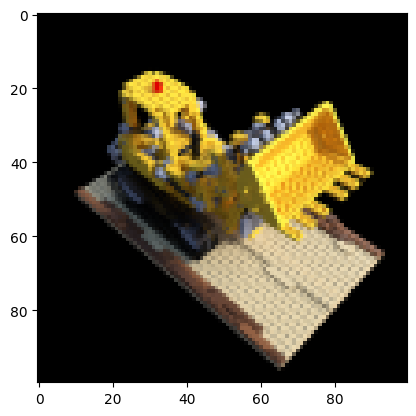

(15, 15, 4, 3)


In [ ]:
import torch
import torch.nn as nn

try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

if IN_COLAB:
    %tensorflow_version 2.x

import os, sys
import tensorflow as tf
tf.compat.v1.enable_eager_execution()

from tqdm import tqdm_notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt

if not os.path.exists('tiny_nerf_data.npz'):
    !wget http://cseweb.ucsd.edu/~viscomp/projects/LF/papers/ECCV20/nerf/tiny_nerf_data.npz

data = np.load('tiny_nerf_data.npz')
images = data['images']
poses = data['poses']
focal = data['focal']
H, W = images.shape[1:3]
print(images.shape, poses.shape, focal)

testimg, testpose = images[101], poses[101]
images = images[:100,...,:3]
poses = poses[:100]
plt.imshow(testimg)
plt.show()

L_embed = 6

def posenc(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [tf.sin, tf.cos]:
      rets.append(fn(2.**i * x))
  return tf.concat(rets, -1)

def posenc_torch(x):
  rets = [x]
  for i in range(L_embed):
    for fn in [torch.sin, torch.cos]:
      rets.append(fn(2.**i * x))
  return torch.concat(rets, dim = -1)

embed_fn = posenc
embed_fn_torch = posenc_torch


# ------------------------------------- TEST POSENC ---------------------------------------------------

posenc_tf_test_tensor = tf.random.uniform((10000, 3), dtype=tf.float32)
posenc_pt_test_tensor = torch.from_numpy(posenc_tf_test_tensor.numpy())
assert np.allclose(posenc_torch(posenc_pt_test_tensor).numpy(), posenc(posenc_tf_test_tensor).numpy())

# -----------------------------------------------------------------------------------------------------

# L_embed = 0
# embed_fn = tf.identity

def init_model(D=8, W=256):
    relu = tf.keras.layers.ReLU()
    dense = lambda W=W, act=relu : tf.keras.layers.Dense(W, activation=act)

    inputs = tf.keras.Input(shape=(3 + 3*2*L_embed))
    outputs = inputs
    for i in range(D):
        outputs = dense()(outputs)
        if i%4==0 and i>0:
            outputs = tf.concat([outputs, inputs], -1)
    outputs = dense(4, act=None)(outputs)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

class InitModelTorch(nn.Module):
  def __init__(self, depth=8, W=256, channel = (3 + 3*2*L_embed), device="cuda"):
    super(InitModelTorch, self).__init__()
    self.model = nn.Sequential()
    self.device = torch.device(device)
    mlp = lambda input_dim=W, output_dim=W: nn.Sequential(nn.Linear(input_dim, output_dim), nn.ReLU())
    self.model.add_module(f"fc{0}", mlp(channel, W))
    for i in range(1,depth,1):
      if not (i%4==1 and i>1):
        self.model.add_module(f"fc{i}", mlp(W, W))
      else:
        self.model.add_module(f"fc{i}", mlp(W + channel, W))
    self.model.add_module("fcn", nn.Linear(W, 4))
    self.initialize_weights()

  def initialize_weights(self):
    for m in self.modules():
      if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
          nn.init.zeros_(m.bias)

  def forward(self, x):
    x = x.to(self.device)
    output = x
    for layer_idx, layer in enumerate(self.model):
      if (layer_idx%4==1 and layer_idx>1):
        output = torch.cat((output, x), dim=-1)
      output = layer(output)
    return output

# ------------------------------------  TEST MODEL ----------------------------------------------------
tf_test_input = tf.random.uniform((15, 3 + 3*2*L_embed))
pt_test_input = torch.tensor(tf_test_input.numpy())
tf_model = init_model()
pt_model = InitModelTorch(device='cpu')

tf_weights = []
for tf_layer in tf_model.layers:
   if isinstance(tf_layer, tf.keras.layers.Dense):
      tf_weights.append(tf_layer.get_weights())
assert len(tf_weights) == len(pt_model.model)
for tf_weight, pt_layer in zip(tf_weights, pt_model.model):
    if isinstance(pt_layer, nn.Sequential):

      assert isinstance(pt_layer[0], nn.Linear)
      pt_layer[0].weight.data = torch.from_numpy(tf_weight[0].T).float()
      pt_layer[0].bias.data = torch.from_numpy(tf_weight[1]).float()
    elif isinstance(pt_layer, nn.Linear):
      weights, biases = tf_layer.get_weights()
      pt_layer.weight.data = torch.from_numpy(tf_weight[0].T).float()
      pt_layer.bias.data = torch.from_numpy(tf_weight[1]).float()


assert np.allclose(tf_model(tf_test_input).numpy(), pt_model(pt_test_input).detach().numpy(), rtol = 0.001), f"{tf_model(tf_test_input).numpy()}\n\n\n, {pt_model(pt_test_input).detach().numpy()}"

# -----------------------------------------------------------------------------------------------------

def get_rays_torch(H, W, focal, c2w):
    '''
    c2w should be the 4x4 transformation matrix from camera coordinate system to world coordinate system (pose matrix)
    c2w[:3,:3]: rotation matrix
    c2w[:3,-1]: translation vector
    rays_d: W x H x 3 matrix, pixel-wise ray direction

    --------------------------------------------------------------------
    Rendering a view from our continuous neural radiance field requires
    estimating this integral C(r) for a camera ray traced through each
    pixel of the desired virtual camera.
    --------------------------------------------------------------------
    '''
    i, j = torch.meshgrid(torch.arange(W), torch.arange(H), indexing='xy')
    dirs = torch.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -torch.ones_like(i)], -1)
    rays_d = torch.sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)   # ray direction in world coordinate system
    rays_o = torch.broadcast_to(c2w[:3,-1], rays_d.size())          # ray origin in world coordinate system
    return rays_o, rays_d

def get_rays(H, W, focal, c2w):
    i, j = tf.meshgrid(tf.range(W, dtype=tf.float32), tf.range(H, dtype=tf.float32), indexing='xy')
    dirs = tf.stack([(i-W*.5)/focal, -(j-H*.5)/focal, -tf.ones_like(i)], -1)
    rays_d = tf.reduce_sum(dirs[..., np.newaxis, :] * c2w[:3,:3], -1)
    rays_o = tf.broadcast_to(c2w[:3,-1], tf.shape(rays_d))
    return rays_o, rays_d

# ---------------------------- TEST GET RAY -----------------------------------------------------------------------------
test_W = test_H = 15
c2w_test = np.random.rand(4,4)
tf_test_rays_o, tf_test_rays_d = get_rays(test_W,test_H,5,tf.convert_to_tensor(c2w_test, dtype=float))
pt_test_rays_o, pt_test_rays_d = get_rays_torch(test_W,test_H,5,torch.tensor(c2w_test, dtype=float))
assert np.allclose(tf_test_rays_o.numpy(), pt_test_rays_o.numpy())
assert np.allclose(tf_test_rays_d.numpy(), pt_test_rays_d.numpy(), rtol=0.01), f"{tf_test_rays_d.numpy()}\n, {pt_test_rays_d.numpy()}"
# -------------------------------------------------------------------------------------------------------------------------


def render_rays(network_fn, rays_o, rays_d, near, far, N_samples, rand=False):

    def batchify(fn, chunk=1024*32):
        return lambda inputs : tf.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)

    # Compute 3D query points
    z_vals = tf.linspace(near, far, N_samples)
    if rand:
      z_vals += tf.random.uniform(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]

    # Run network
    pts_flat_1 = tf.reshape(pts, [-1,3])
    pts_flat = embed_fn(pts_flat_1)
    raw = batchify(network_fn)(pts_flat)
    raw = tf.reshape(raw, list(pts.shape[:-1]) + [4])

    # Compute opacities and colors
    sigma_a = tf.nn.relu(raw[...,3])
    rgb = tf.math.sigmoid(raw[...,:3])

    # Do volume rendering
    dists = tf.concat([z_vals[..., 1:] - z_vals[..., :-1], tf.broadcast_to([1e10], z_vals[...,:1].shape)], -1)
    alpha = 1.-tf.exp(-sigma_a * dists)
    weights = alpha * tf.math.cumprod(1.-alpha + 1e-10, -1, exclusive=True)

    rgb_map = tf.reduce_sum(weights[...,None] * rgb, -2)
    depth_map = tf.reduce_sum(weights * z_vals, -1)
    acc_map = tf.reduce_sum(weights, -1)

    return rgb_map, depth_map, acc_map

def render_rays_torch(network_fn, rays_o, rays_d, near, far, N_samples, rand=False, device = 'cuda'):
    '''
    near and far are floats
    '''
    # torch.set_default_tensor_type(torch.cuda.FloatTensor)
    def batchify(fn, chunk=1024*32):
        return lambda inputs : torch.concat([fn(inputs[i:i+chunk]) for i in range(0, inputs.shape[0], chunk)], 0)

    # Compute 3D query points
    z_vals = torch.linspace(near, far, N_samples) # divide tn, tf into segments of number N_samples
    if rand:
      z_vals = z_vals.view(1,1,N_samples) + torch.rand(list(rays_o.shape[:-1]) + [N_samples]) * (far-near)/N_samples # add noise (0, interval) to each segments
    pts = rays_o[...,None,:] + rays_d[...,None,:] * z_vals[...,:,None]  # pts are world coordinates along the ray line

    # Run network
    pts_flat_1 = torch.reshape(pts, [-1,3])  # create a query of xyz for image_pixel.flatten()
    pts_flat = embed_fn_torch(pts_flat_1)          # encode world position information into

    raw = batchify(network_fn)(pts_flat.to(torch.float32))
    raw = torch.reshape(raw, list(pts.shape[:-1]) + [4])

    # Compute opacities and colors
    sigma_a = nn.ReLU()(raw[...,3])
    rgb = torch.sigmoid(raw[...,:3])

    # Do volume rendering
    dists = torch.concat([z_vals[..., 1:] - z_vals[..., :-1], torch.broadcast_to(torch.tensor([1e10]), z_vals[...,:1].shape)], -1)  # Why do we need to add t= infinite positive 1e10 to the end of ray line?
    alpha = 1.-torch.exp(-sigma_a * (dists.to(torch.device(device))))  # (1 − exp(−σiδi))
    cumprod_tensor = 1.-alpha + 1e-10
    exclusive_tensor = torch.cat((torch.ones_like(cumprod_tensor)[...,0:1], cumprod_tensor[...,:-1]), -1)
    weights = alpha * torch.cumprod(exclusive_tensor, -1) # Ti

    rgb_map = torch.sum(weights[...,None] * rgb, -2)
    depth_map = torch.sum(weights * (z_vals.to(torch.device(device))), -1)
    acc_map = torch.sum(weights, -1)

    return rgb_map, depth_map, acc_map

# --------------------------------- TEST RENDER RAY -------------------------------------
def error_msg(mat1, mat2):
  for i,ele in enumerate(mat1):
    print(f"{i} row in matrix 1: {ele}\n")
  for i,ele in enumerate(mat2):
    print(f"{i} row in matrix 2: {ele}\n")
  return "!"
tf_test_rgb_map, tf_test_depth_map, tf_test_acc_map = render_rays(tf_model, tf_test_rays_o, tf_test_rays_d, 2., 4., 4, rand=False)
pt_test_rgb_map, pt_test_depth_map, pt_test_acc_map = render_rays_torch(pt_model, pt_test_rays_o, pt_test_rays_d, 2., 4., 4, rand=False, device='cpu')
# assert np.allclose(tf_test_rgb_map.numpy(), pt_test_rgb_map.detach().numpy(), rtol = 0.001), error_msg(tf_test_rgb_map.numpy(),pt_test_rgb_map.detach().numpy())
# assert np.allclose(tf_test_rgb_map.numpy(), pt_test_rgb_map.detach().numpy(), rtol = 0.001), error_msg(tf_test_rgb_map.numpy(),pt_test_rgb_map.detach().numpy())
#f"{tf_test_raw.numpy()}\n\n\n, {pt_test_raw.detach().numpy()} "

# ---------------------------------------------------------------------------------------


Here we optimize the model. We plot a rendered holdout view and its PSNR every 50 iterations.

In [ ]:
torch.cuda.empty_cache()
!nvidia-smi


Sun Dec 10 16:45:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

0 0.10585100173950196 secs per iter


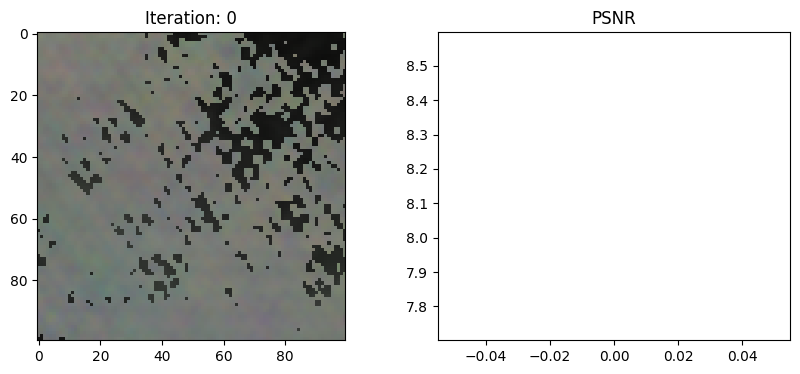

25 1.6704662895202638 secs per iter


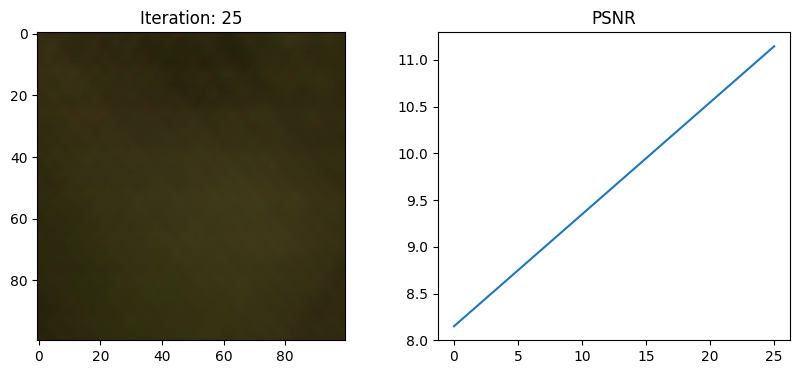

50 1.6574461841583252 secs per iter


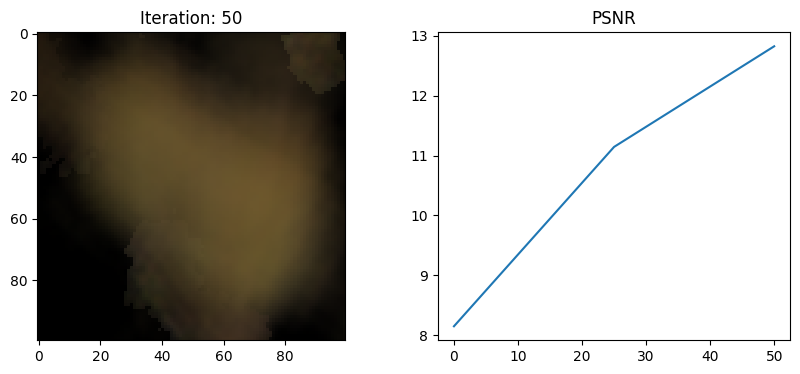

75 1.6217191696166993 secs per iter


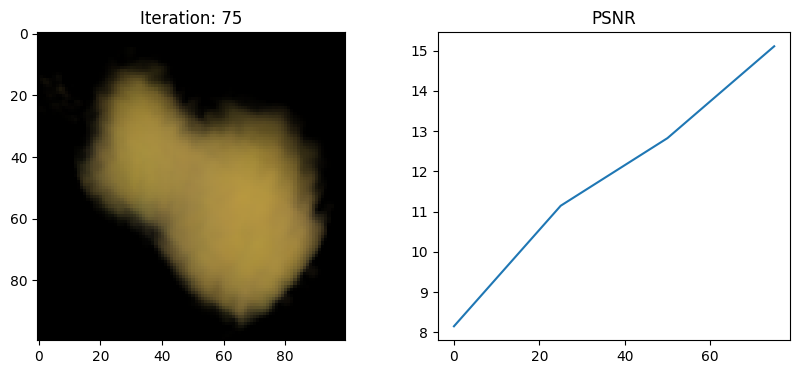

100 1.5838882446289062 secs per iter


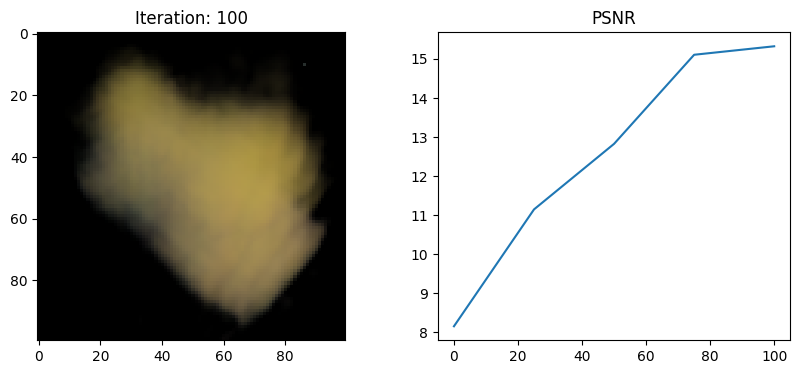

125 1.6072439575195312 secs per iter


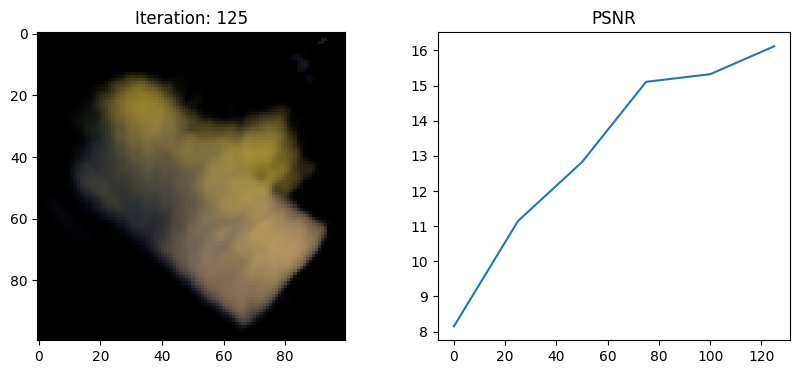

150 1.6451853370666505 secs per iter


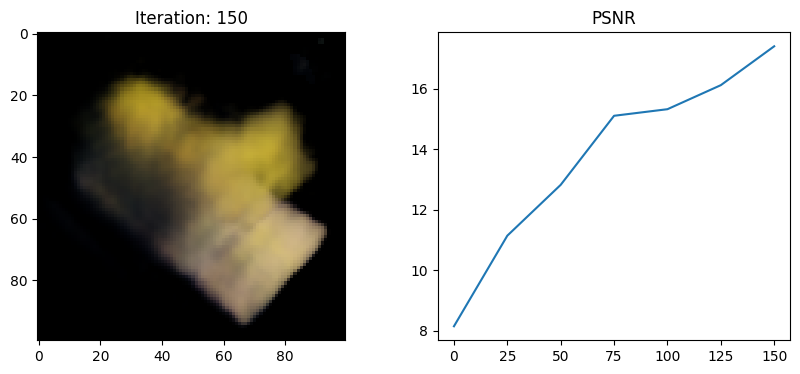

175 1.6149132919311524 secs per iter


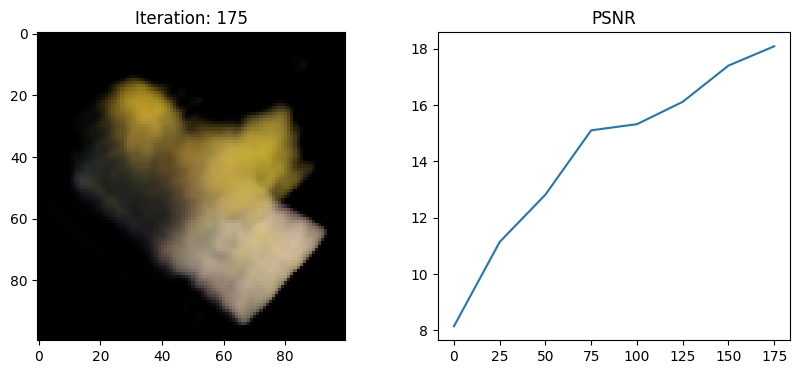

200 1.6089774417877196 secs per iter


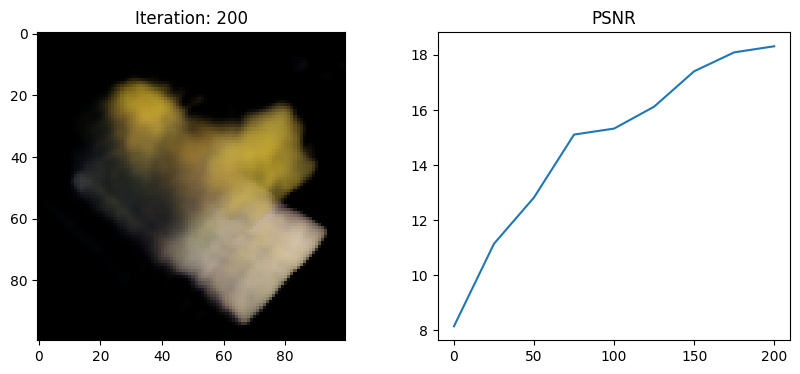

225 1.6066060161590576 secs per iter


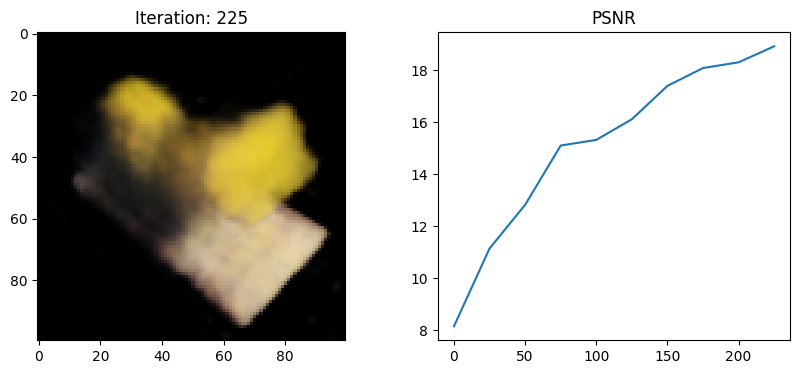

250 1.613772611618042 secs per iter


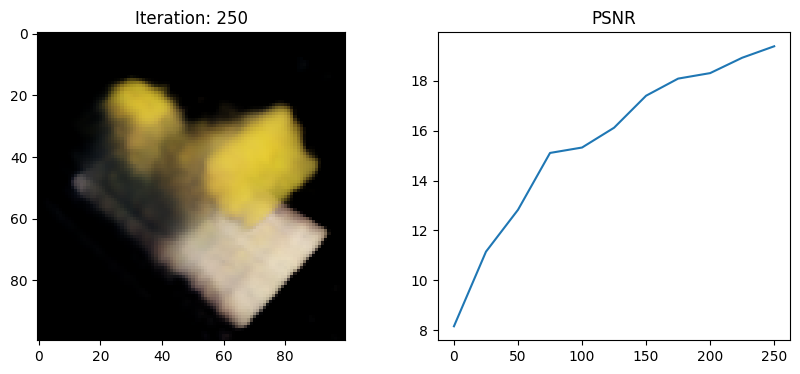

275 1.6308156299591063 secs per iter


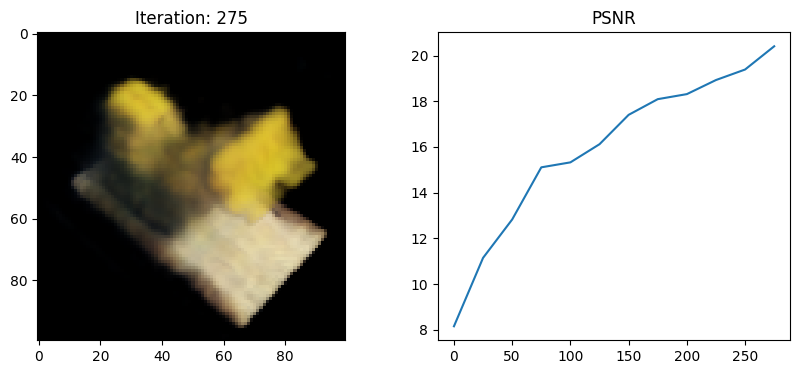

300 1.611656904220581 secs per iter


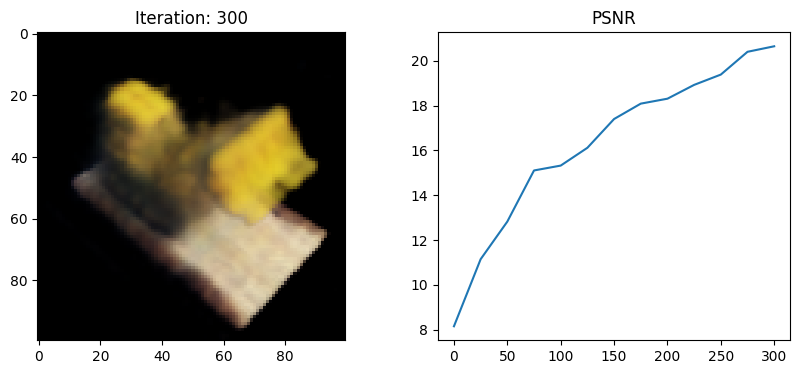

325 1.6299066257476806 secs per iter


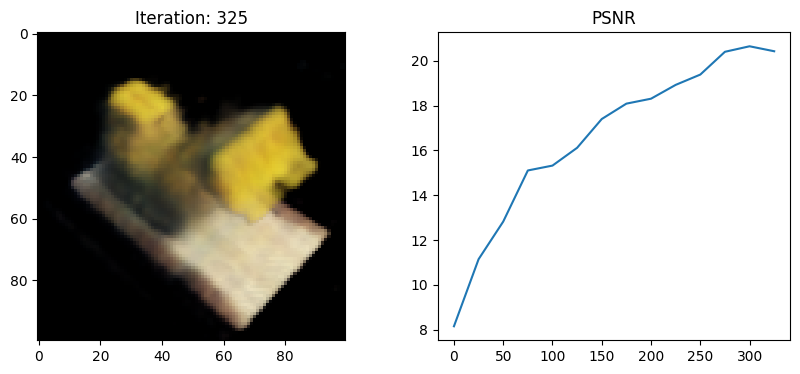

350 1.61590651512146 secs per iter


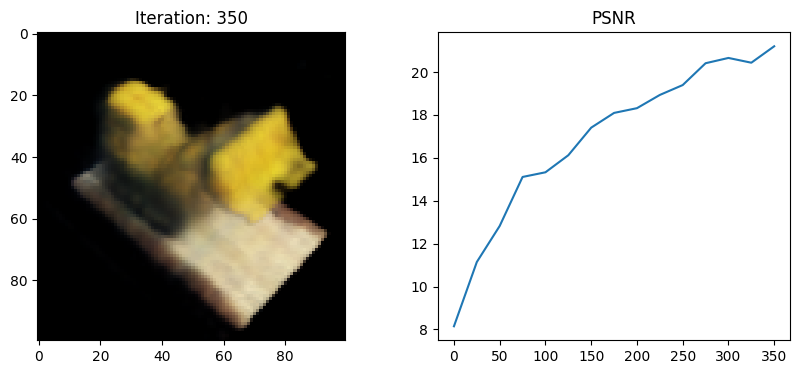

375 1.6155002307891846 secs per iter


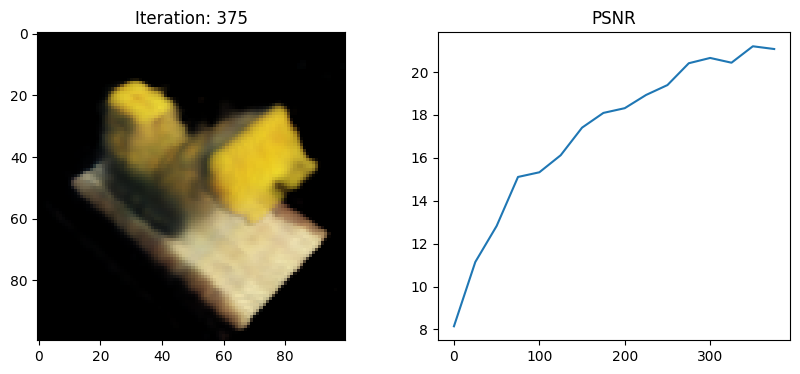

400 1.6147239303588867 secs per iter


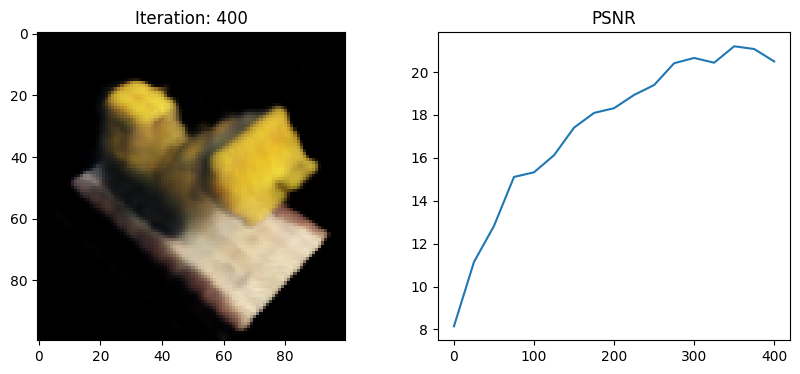

425 1.6148813438415528 secs per iter


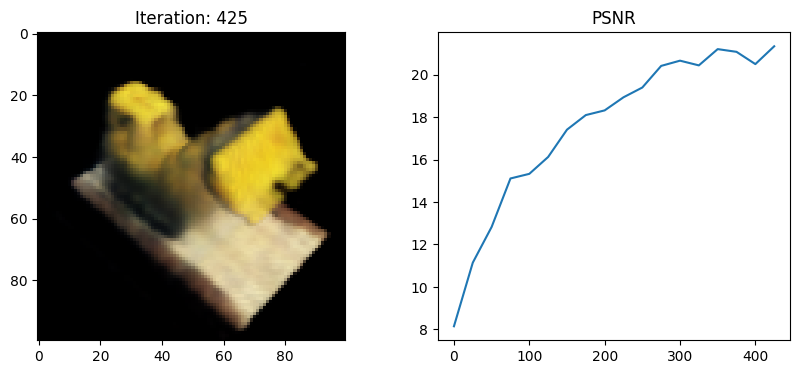

450 1.622502737045288 secs per iter


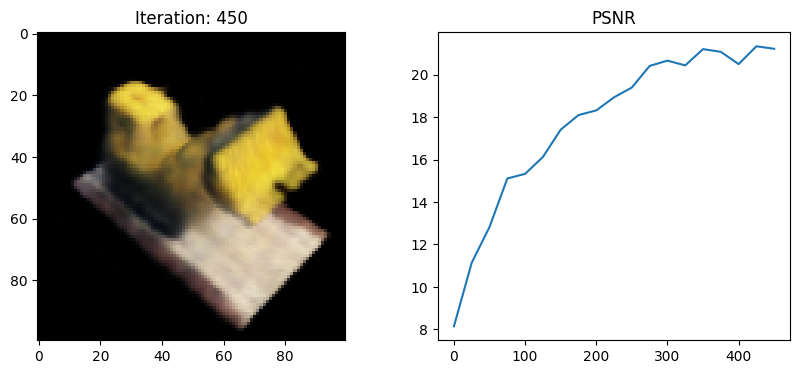

475 1.577000494003296 secs per iter


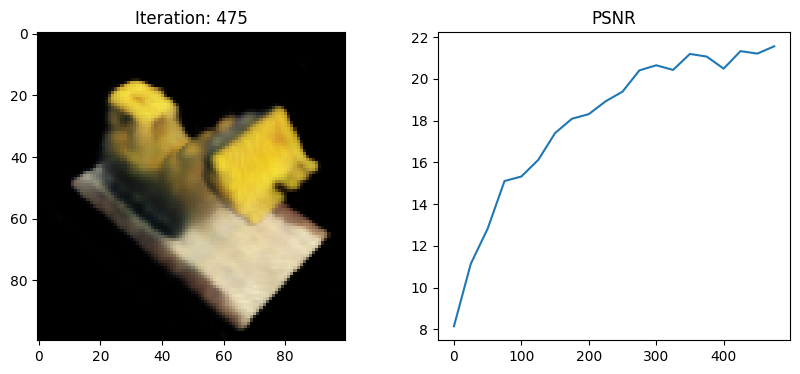

500 1.5621739768981933 secs per iter


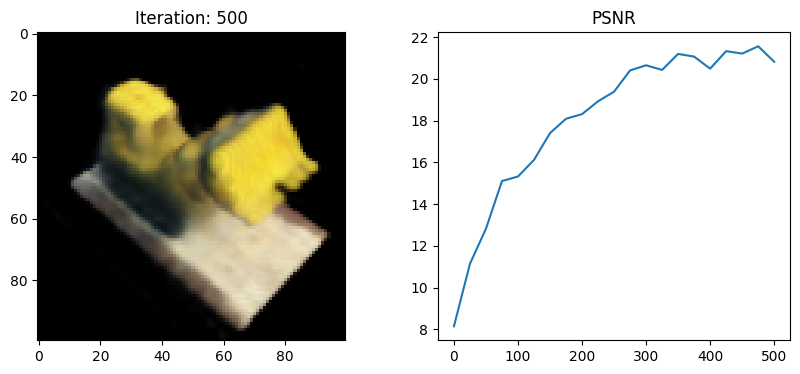

525 1.5773411750793458 secs per iter


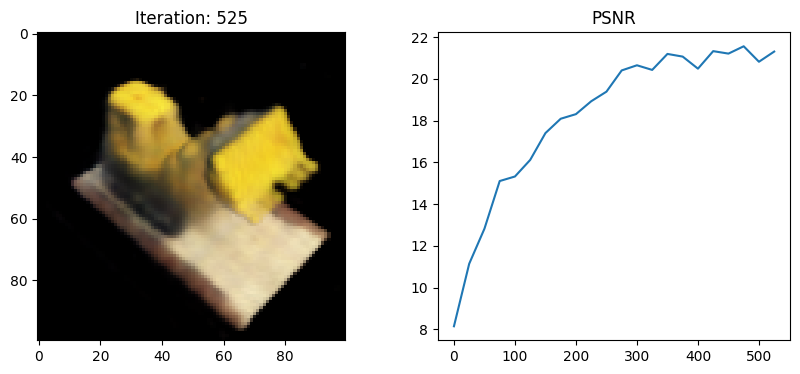

550 1.5616876411437988 secs per iter


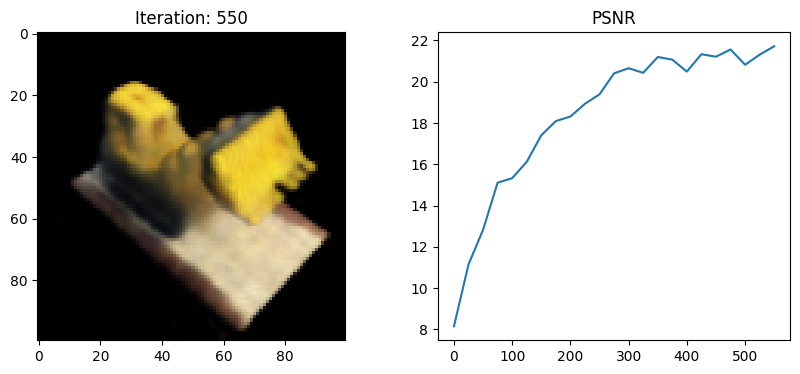

575 1.5602339458465577 secs per iter


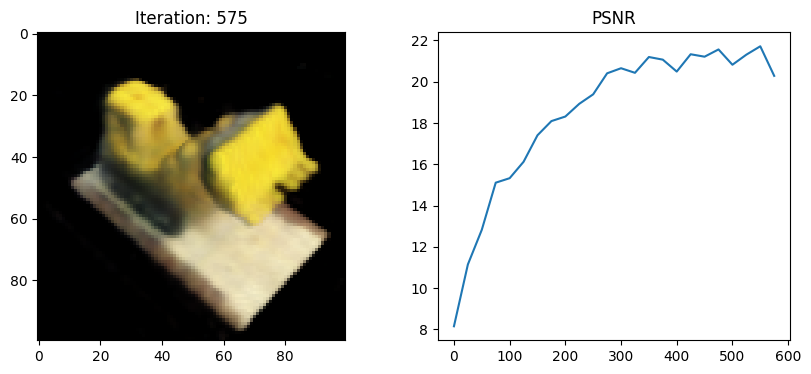

600 1.5648657131195067 secs per iter


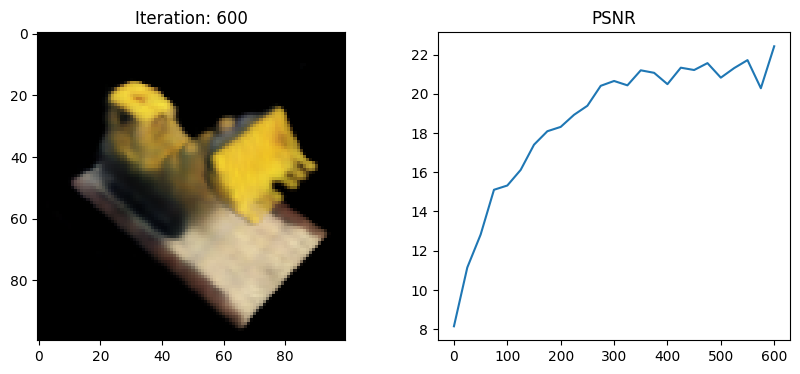

625 1.5692531394958495 secs per iter


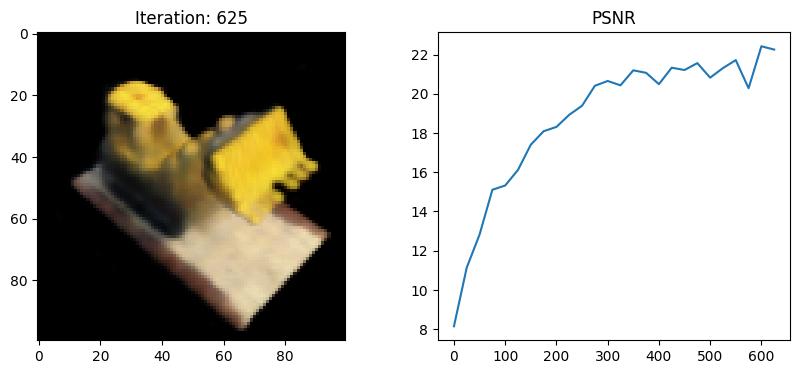

650 1.5642473220825195 secs per iter


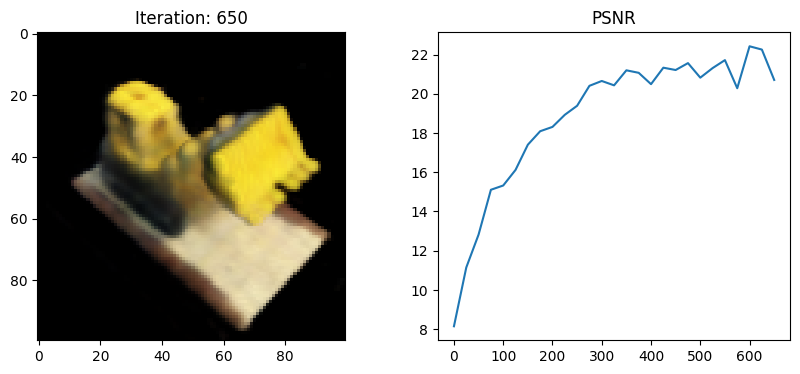

675 1.5772069454193116 secs per iter


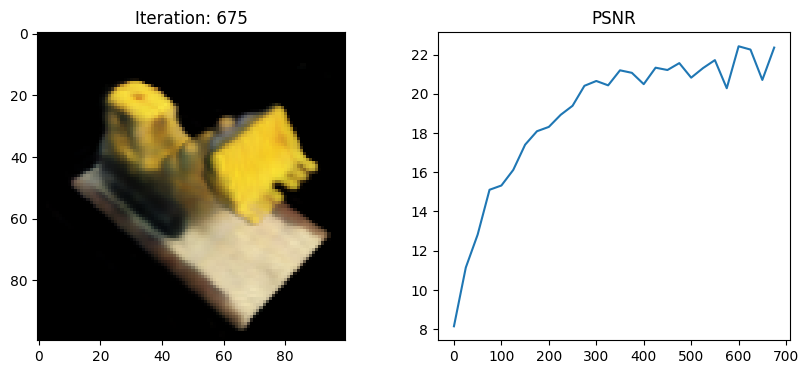

700 1.5949312782287597 secs per iter


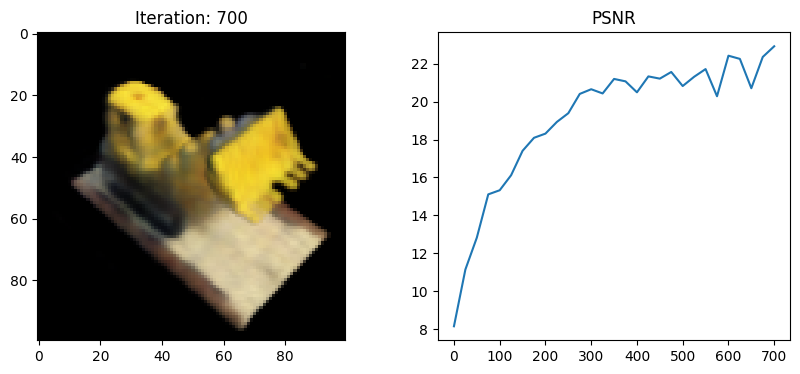

725 1.5954436492919921 secs per iter


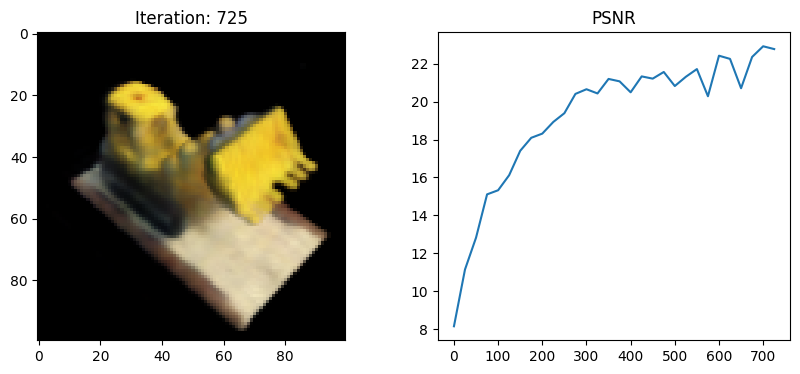

750 1.5975613212585449 secs per iter


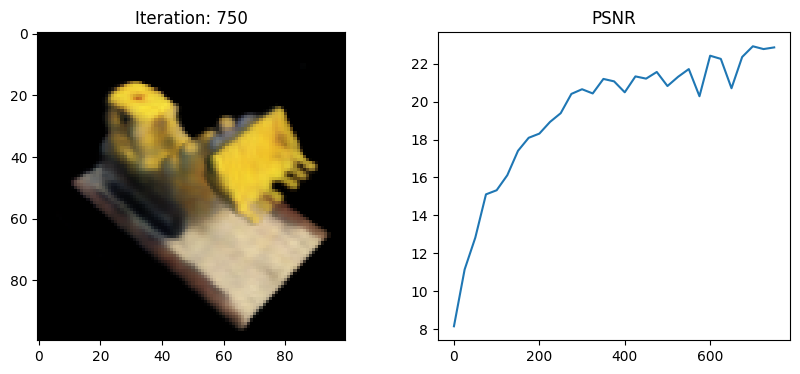

775 1.5956283855438231 secs per iter


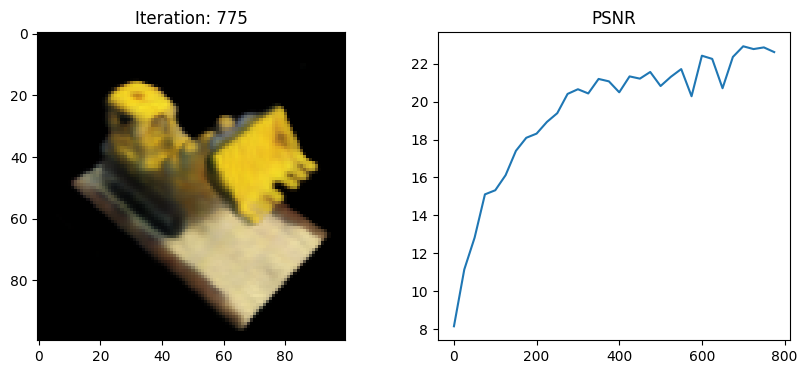

800 1.5854518699645996 secs per iter


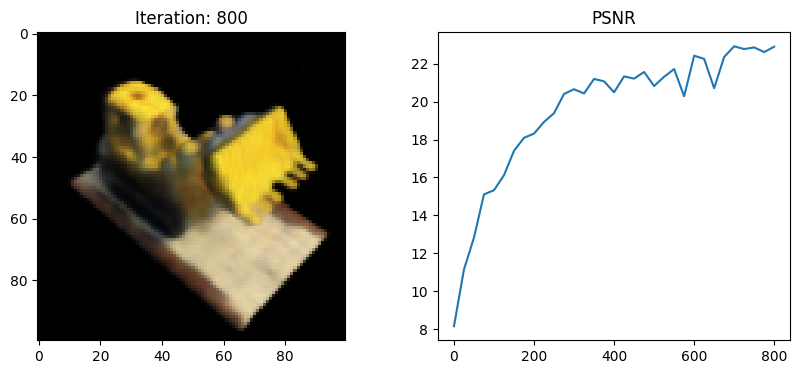

825 1.5970937728881835 secs per iter


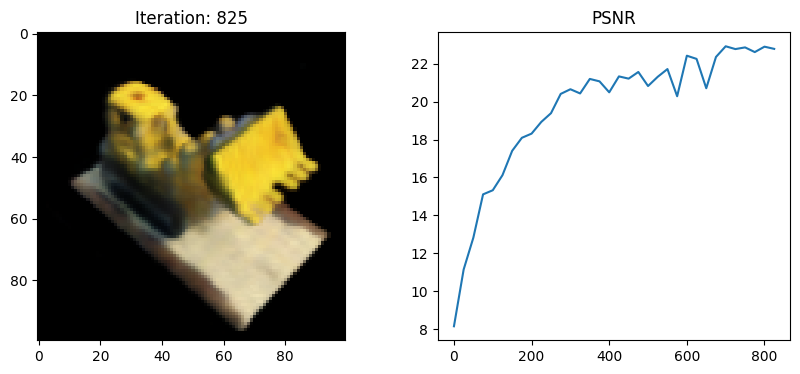

850 1.588725061416626 secs per iter


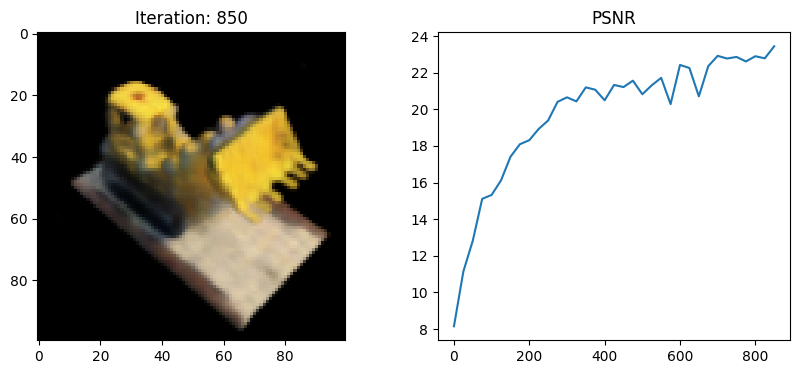

875 1.5890602111816405 secs per iter


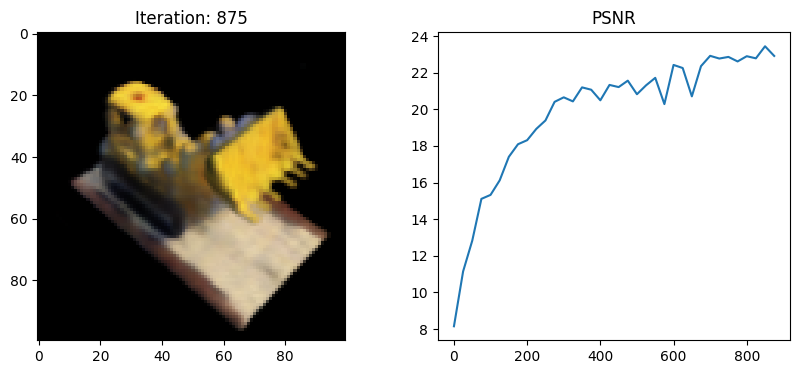

900 1.6093530559539795 secs per iter


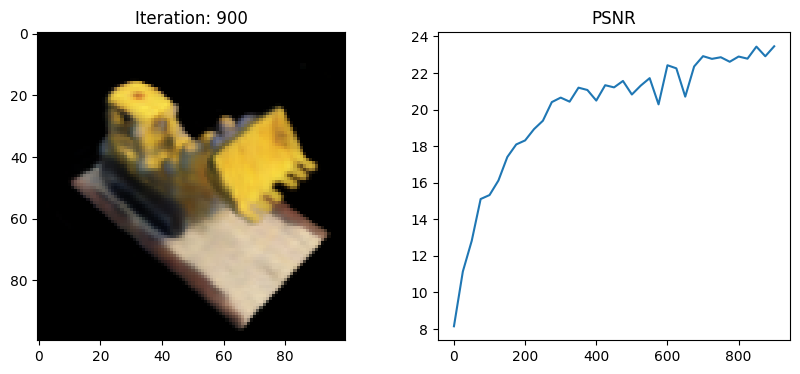

925 1.585540647506714 secs per iter


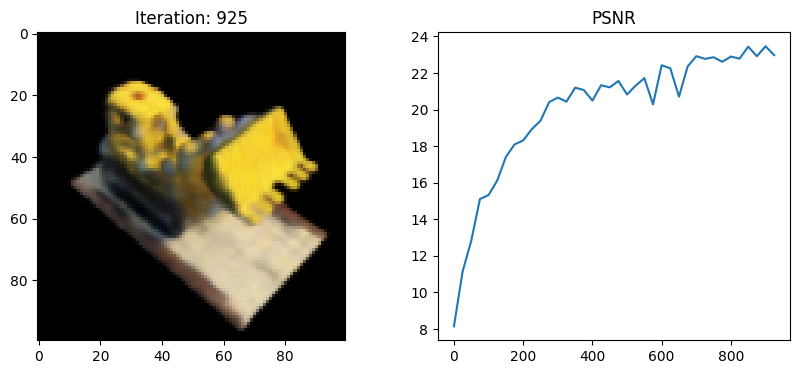

950 1.587948579788208 secs per iter


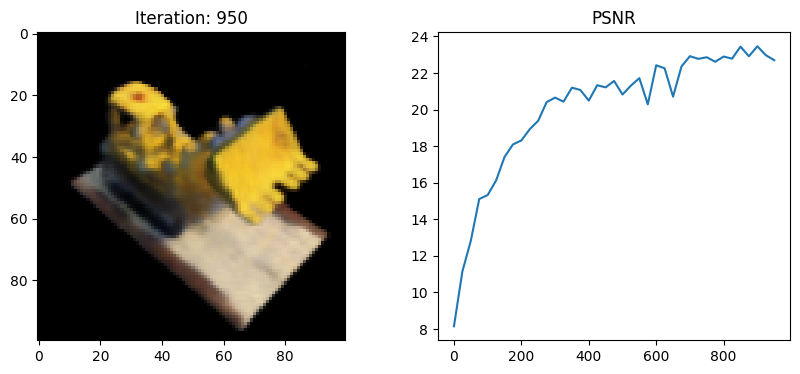

975 1.6047731018066407 secs per iter


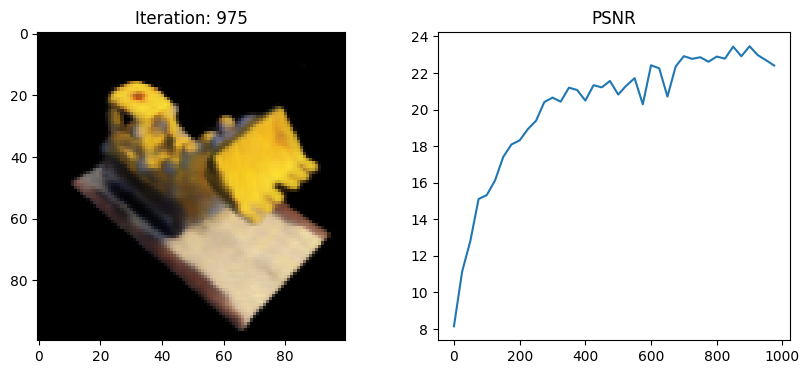

1000 1.591019525527954 secs per iter


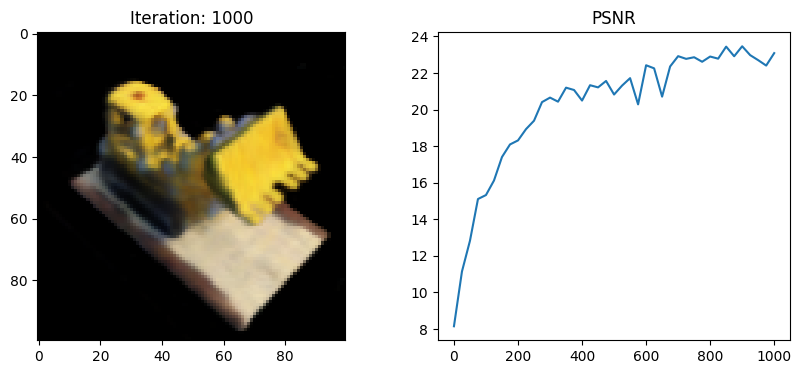

Done


In [ ]:
import torch.nn.functional as F
import math
import gc
gc.collect()
torch.cuda.empty_cache()

device = torch.device("cuda")
model = InitModelTorch()
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 5e-4)
testpose_torch = torch.tensor(testpose).clone().detach()
N_samples = 128
N_iters = 1000
psnrs = []
iternums = []
i_plot = 25
testimg_torch = torch.tensor(testimg).clone().detach().to(device)
import time
t = time.time()
for i in range(N_iters+1):

    # prepare view perspective data
    img_i = np.random.randint(images.shape[0])
    target = torch.tensor(images[img_i]).to(device)
    pose = torch.tensor(poses[img_i])
    rays_o, rays_d = get_rays_torch(H, W, focal, pose)

    rgb, depth, acc = render_rays_torch(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
    loss = F.mse_loss(rgb, target)
    loss.backward()
    optimizer.step()

    optimizer.zero_grad()

    if i%i_plot==0:
        model.eval()
        with torch.no_grad():
            print(i, (time.time() - t) / i_plot, 'secs per iter')
            t = time.time()

            # Render the holdout view for logging
            rays_o, rays_d = get_rays_torch(H, W, focal, testpose_torch)
            rgb, depth, acc = render_rays_torch(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
            loss = torch.mean(torch.square(rgb - testimg_torch))
            psnr = -10. * math.log(loss) / math.log(10.)

            psnrs.append(psnr)
            iternums.append(i)

            plt.figure(figsize=(10,4))
            plt.subplot(121)
            plt.imshow(rgb.cpu())
            plt.title(f'Iteration: {i}')
            plt.subplot(122)
            plt.plot(iternums, psnrs)
            plt.title('PSNR')
            plt.show()
print('Done')


0 0.22440630912780762 secs per iter


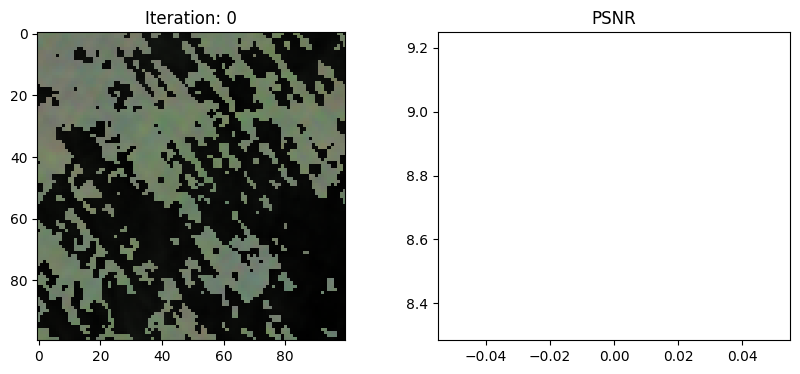

25 0.8373944568634033 secs per iter


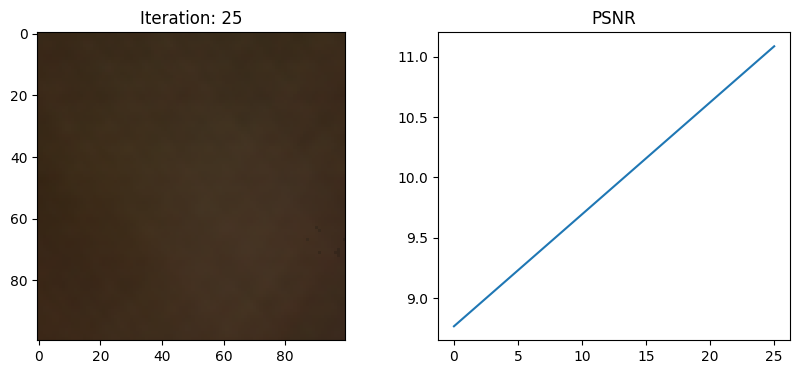

50 0.7415567111968994 secs per iter


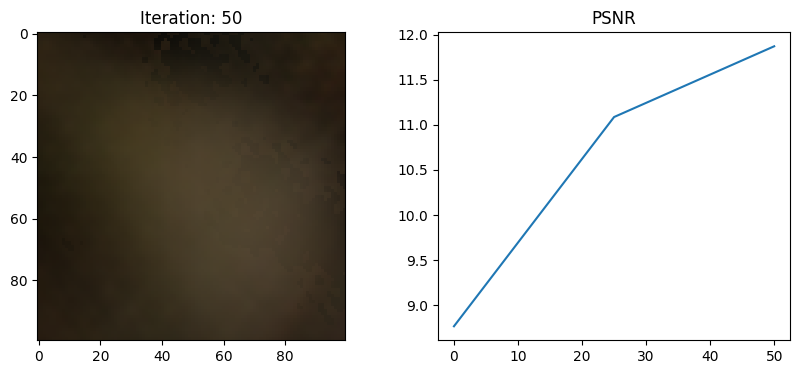

75 0.7118318557739258 secs per iter


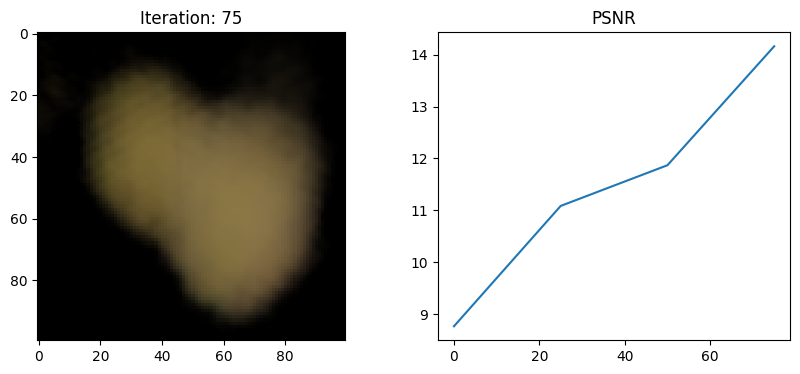

100 0.7091939544677734 secs per iter


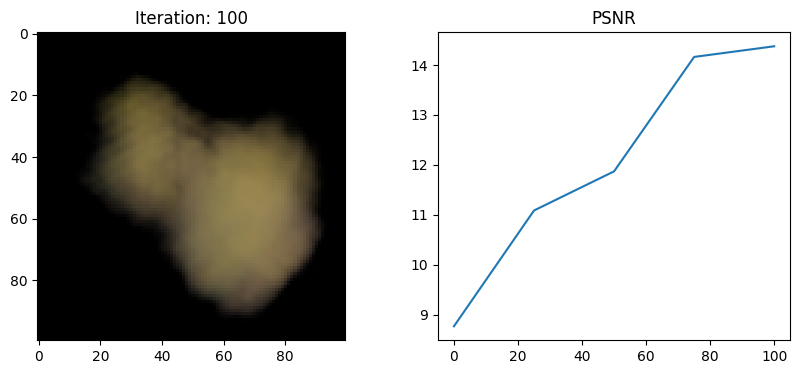

125 0.7127328872680664 secs per iter


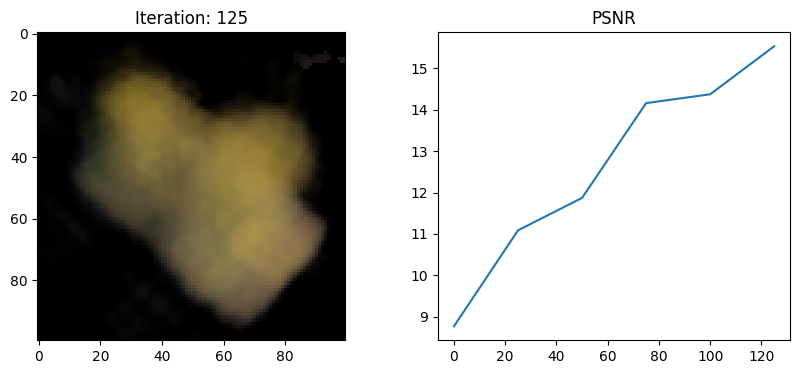

150 0.7526465511322021 secs per iter


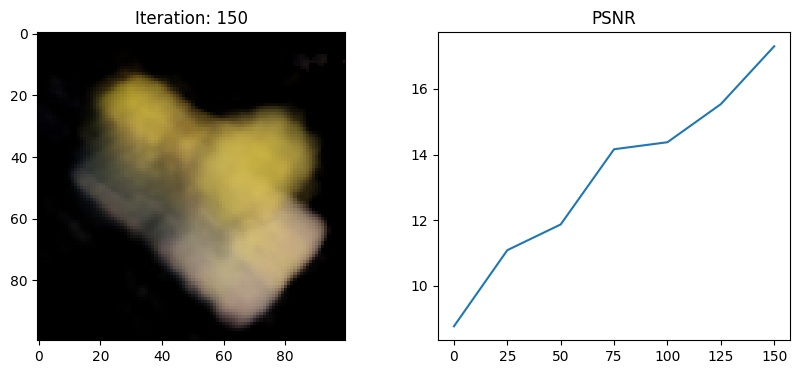

175 0.7339682292938232 secs per iter


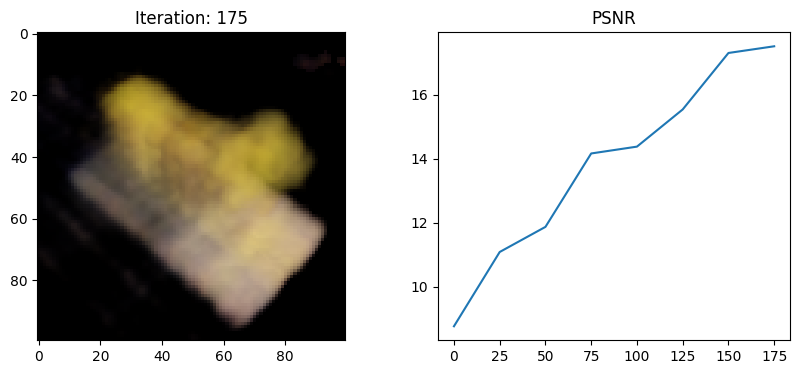

200 0.7352997779846191 secs per iter


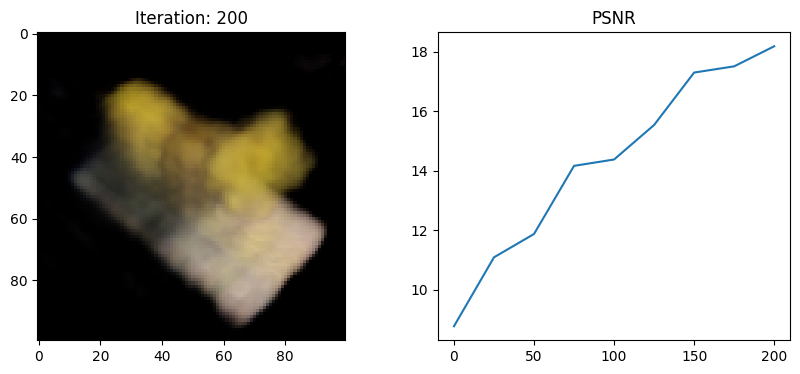

225 0.7462324237823487 secs per iter


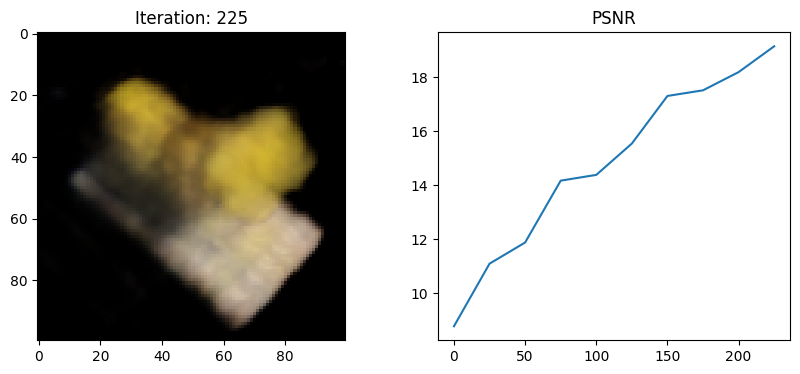

250 0.741184253692627 secs per iter


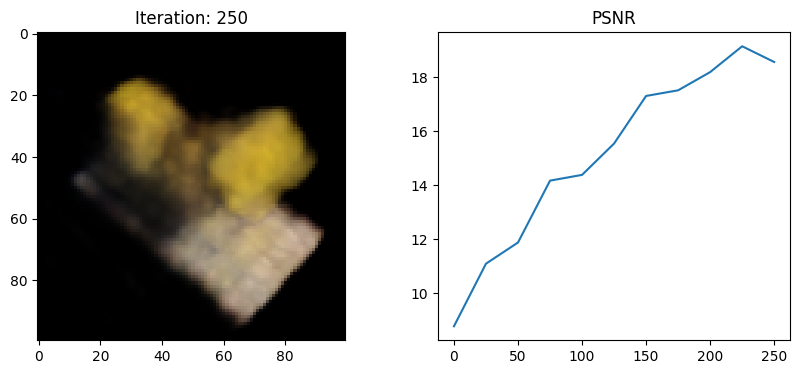

275 0.7418089580535888 secs per iter


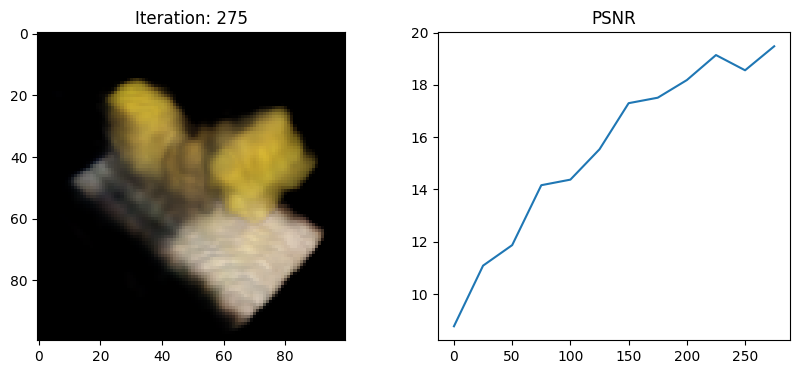

300 0.747149133682251 secs per iter


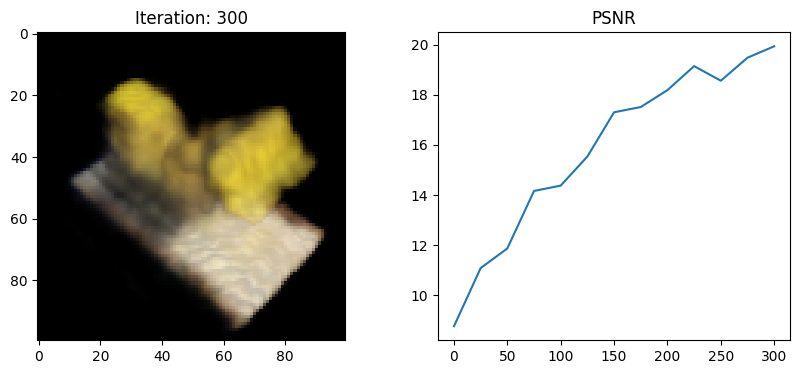

325 0.7393927764892578 secs per iter


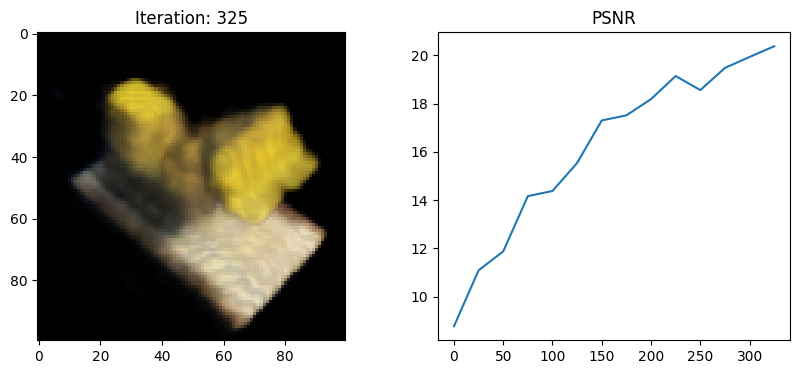

350 0.7415921115875244 secs per iter


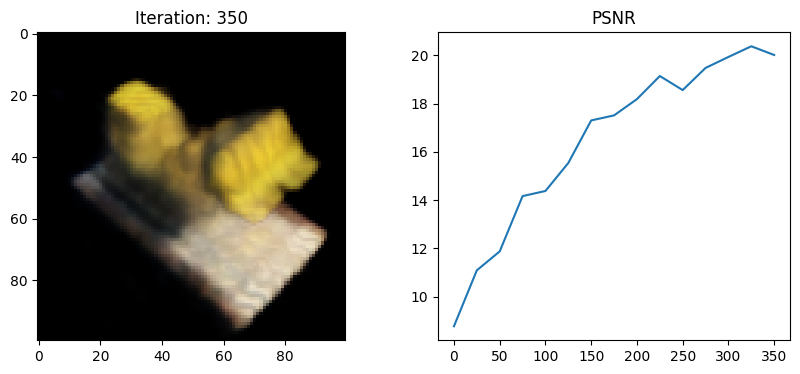

375 0.7425621604919433 secs per iter


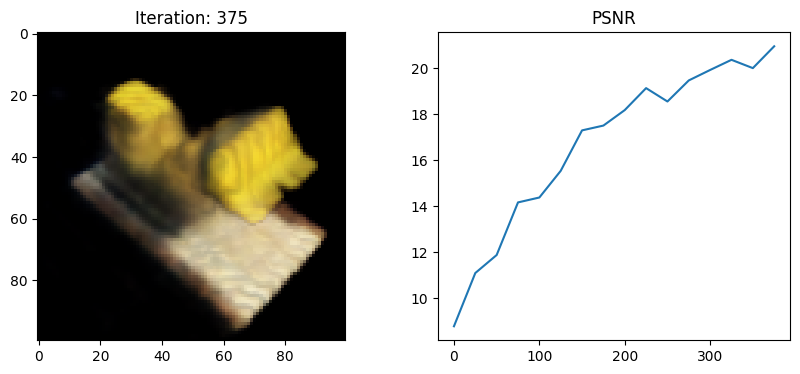

400 0.7402979564666748 secs per iter


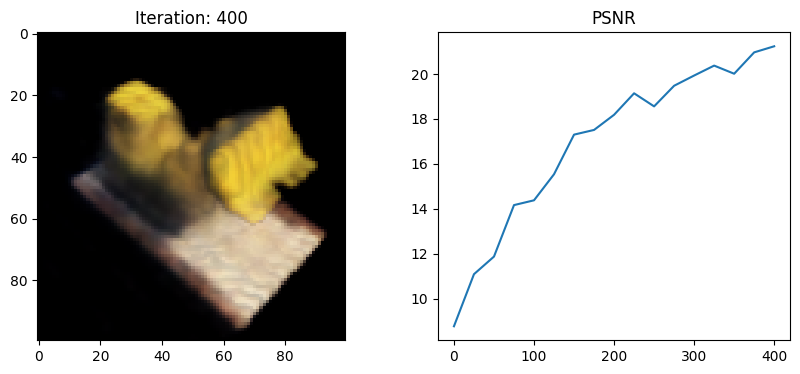

425 0.7433530712127685 secs per iter


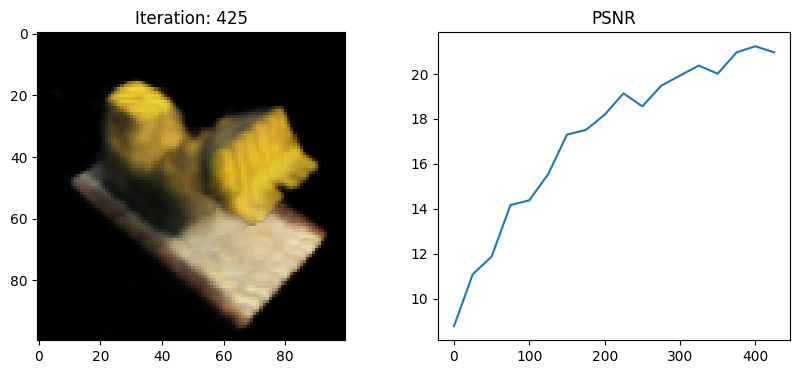

450 0.7465989589691162 secs per iter


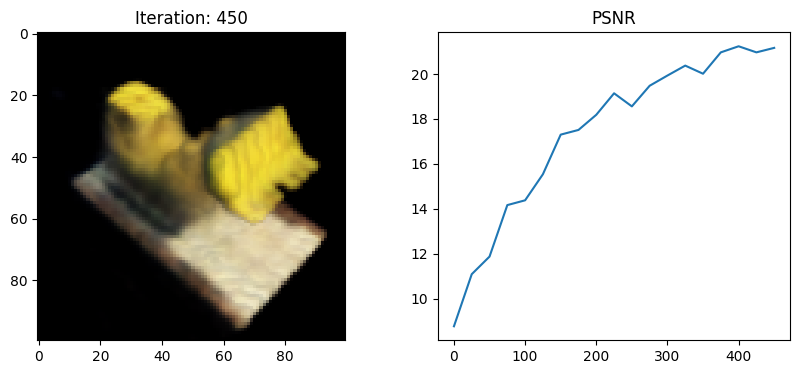

475 0.7393126964569092 secs per iter


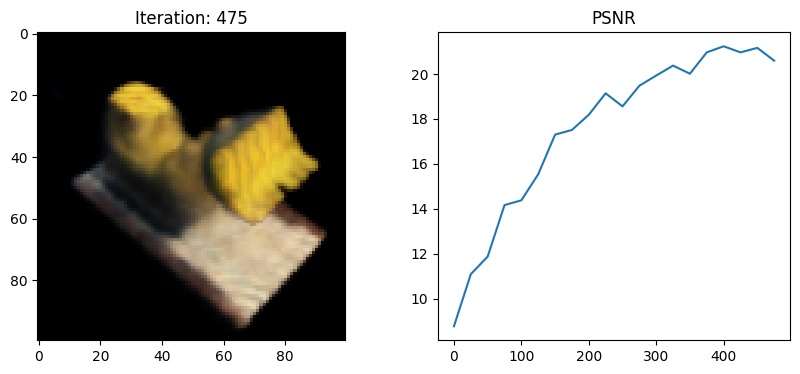

500 0.7357034111022949 secs per iter


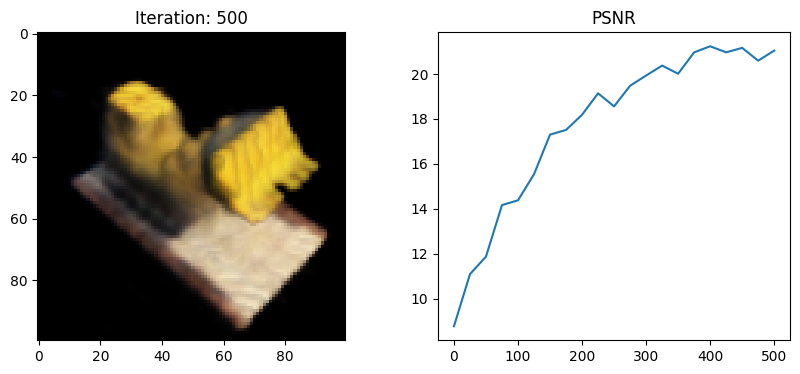

525 0.7371750736236572 secs per iter


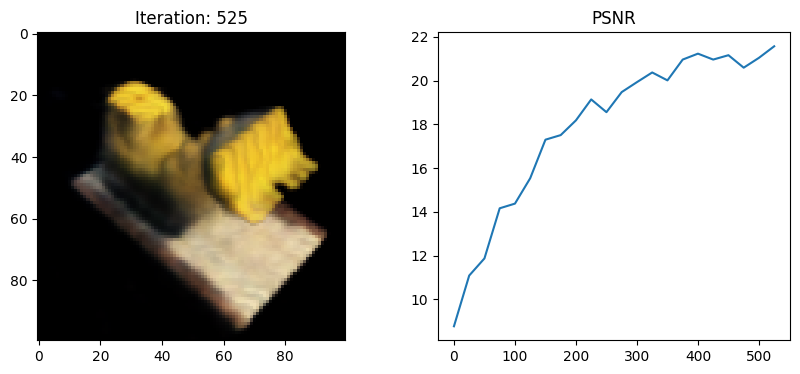

550 0.7427728748321534 secs per iter


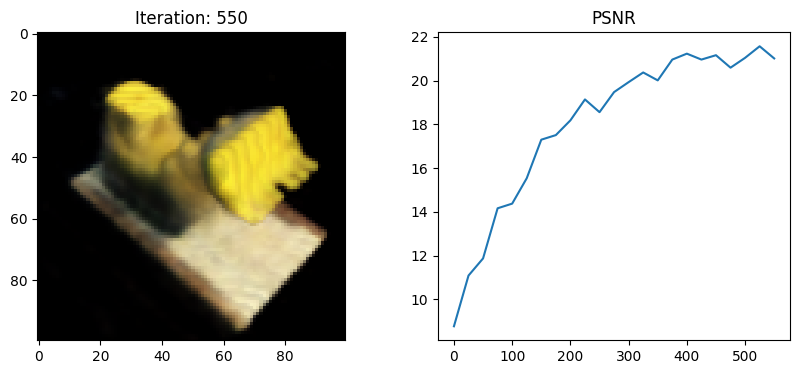

575 0.7361859893798828 secs per iter


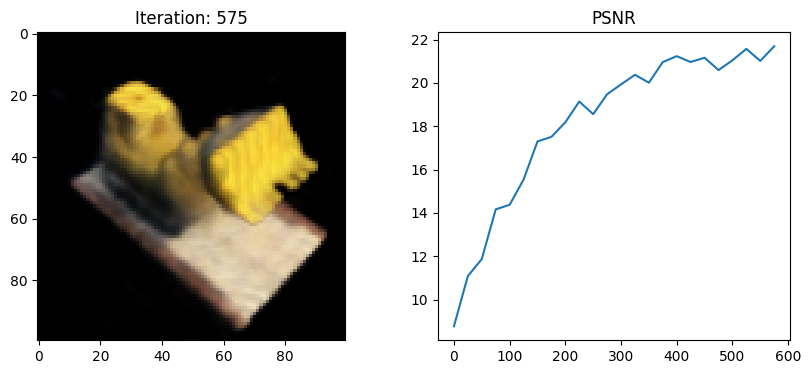

600 0.7428793144226075 secs per iter


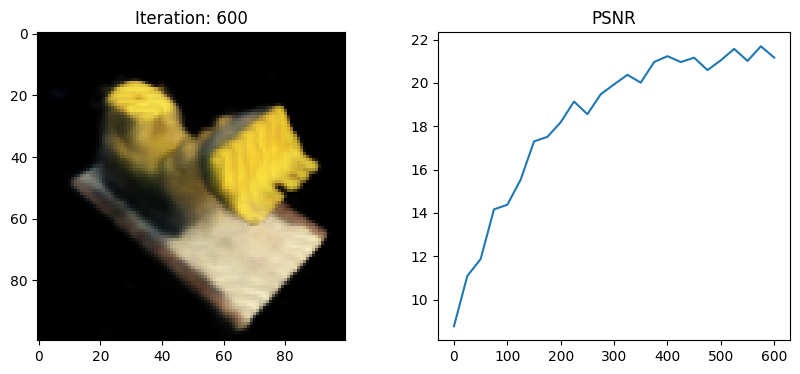

625 0.7373702621459961 secs per iter


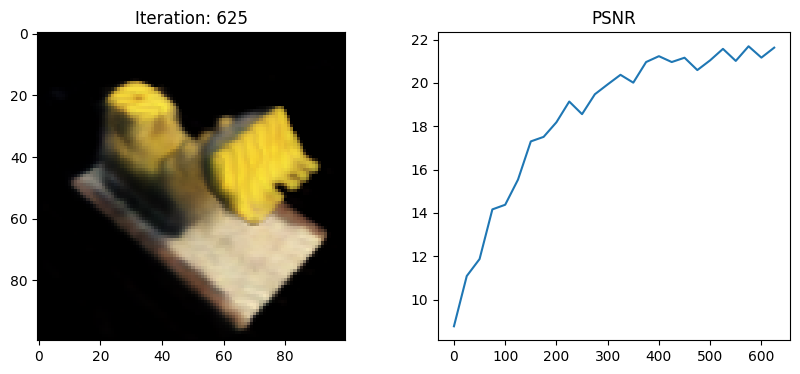

650 0.7424156188964843 secs per iter


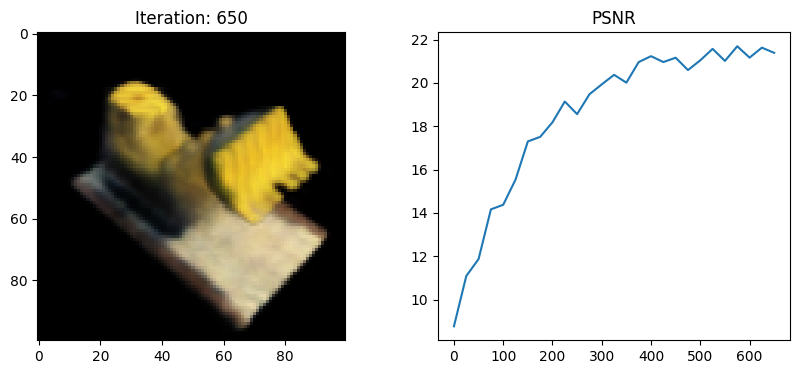

675 0.7404088211059571 secs per iter


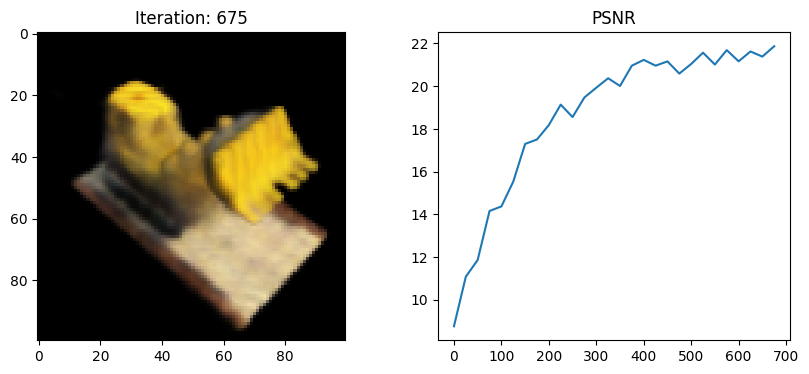

700 0.7393442535400391 secs per iter


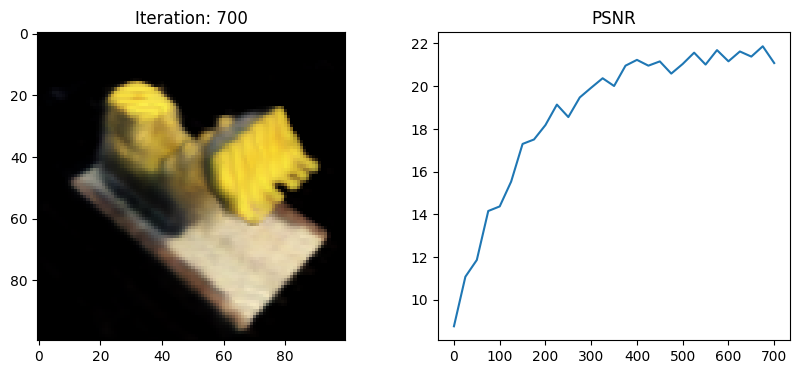

725 0.7377825736999511 secs per iter


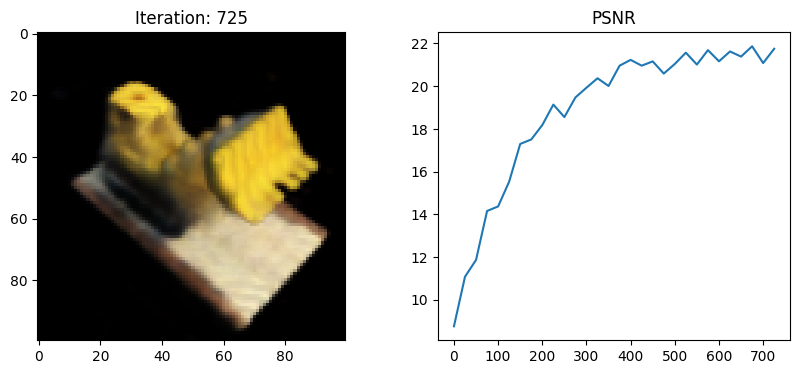

750 0.7511977481842042 secs per iter


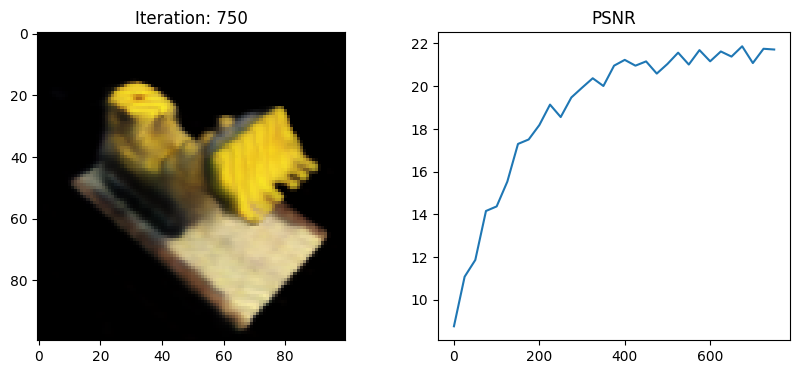

775 0.7385782337188721 secs per iter


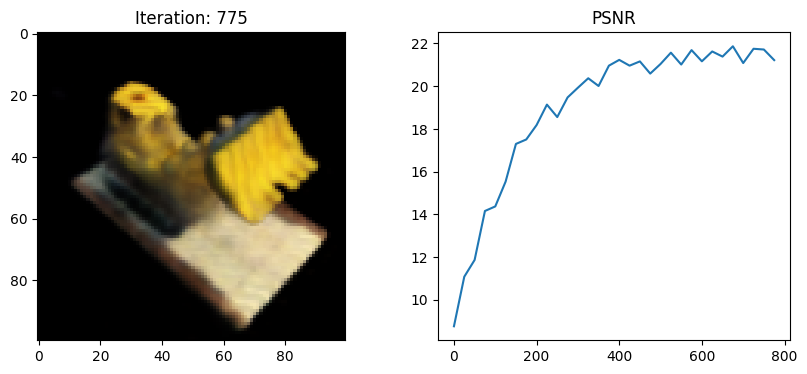

800 0.7415515613555909 secs per iter


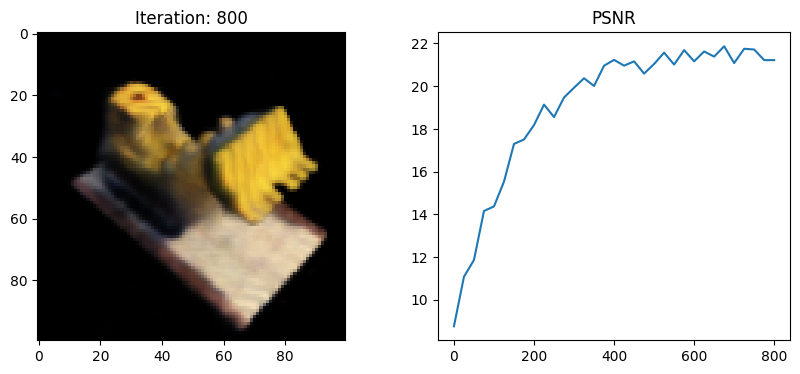

825 0.7396216773986817 secs per iter


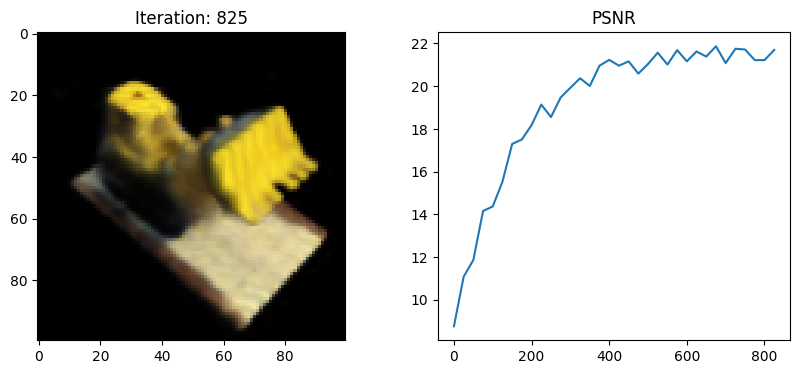

850 0.7437075614929199 secs per iter


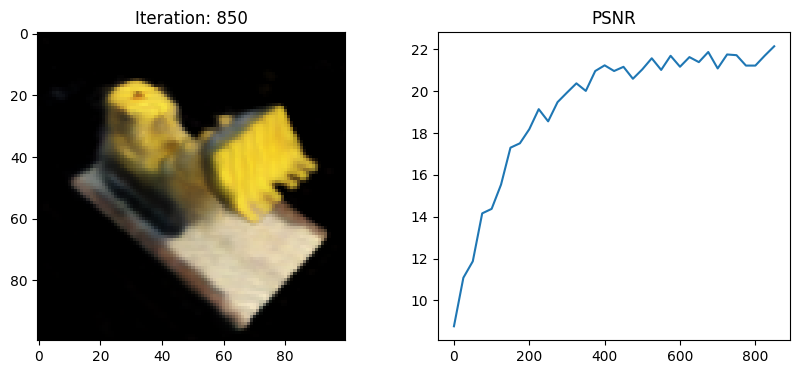

875 0.7434761619567871 secs per iter


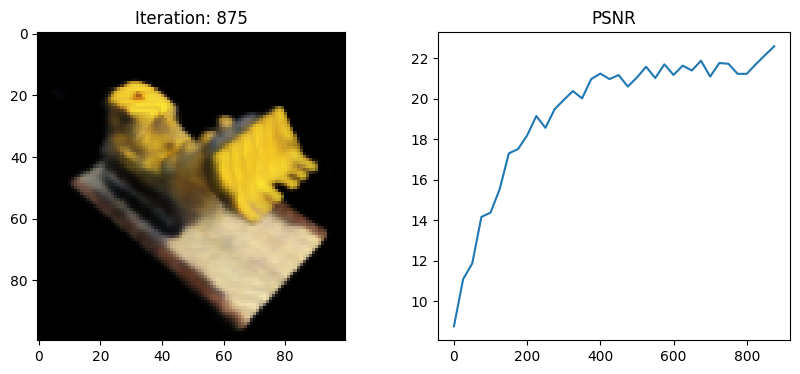

900 0.7376685333251953 secs per iter


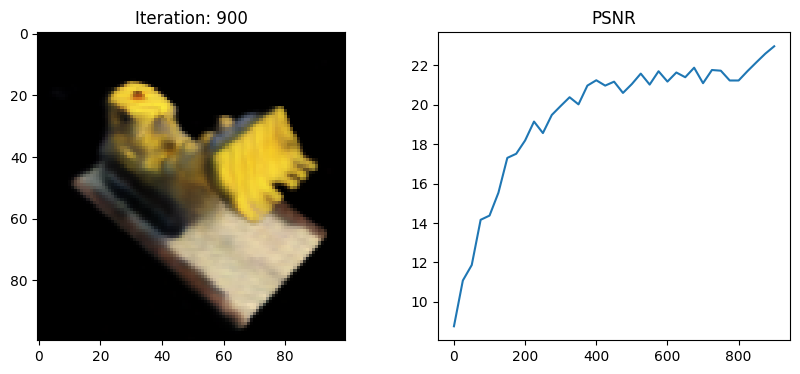

925 0.7427325439453125 secs per iter


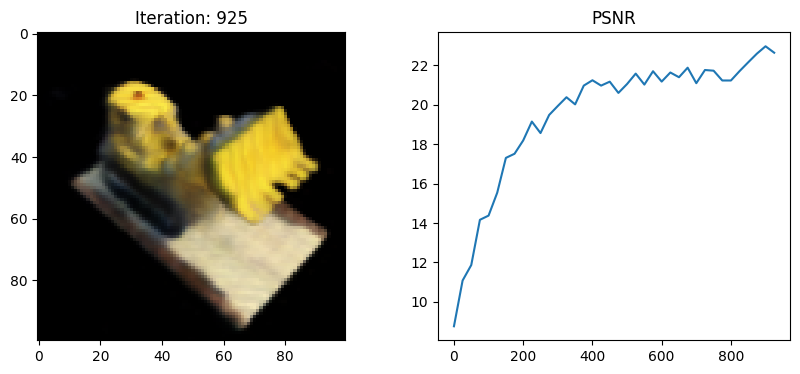

950 0.7379843616485595 secs per iter


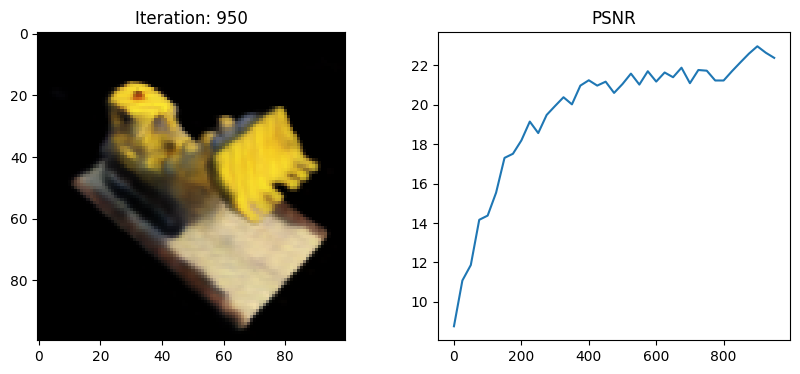

975 0.7383017063140869 secs per iter


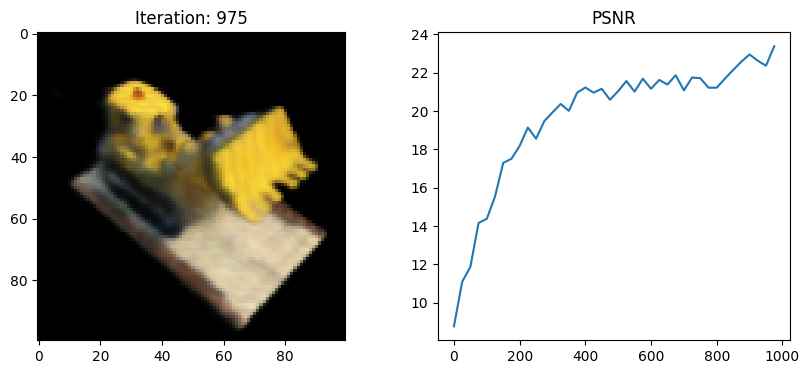

1000 0.7404382038116455 secs per iter


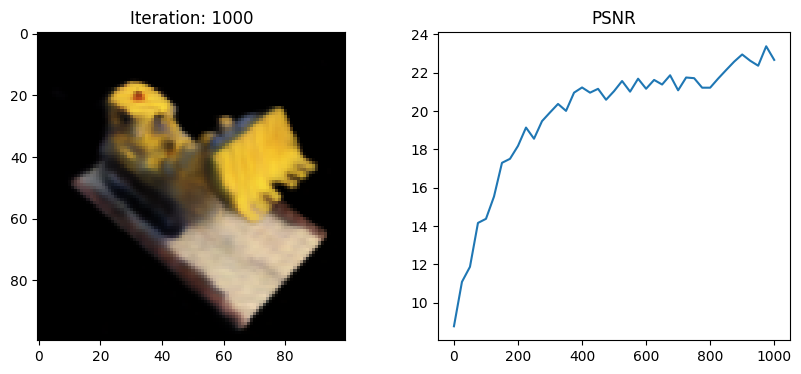

Done


In [ ]:
model = init_model()
optimizer = tf.keras.optimizers.Adam(5e-4)

N_samples = 64
N_iters = 1000
psnrs = []
iternums = []
i_plot = 25

import time
t = time.time()
for i in range(N_iters+1):

    img_i = np.random.randint(images.shape[0])
    target = images[img_i]
    pose = poses[img_i]
    rays_o, rays_d = get_rays(H, W, focal, pose)
    with tf.GradientTape() as tape:
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples, rand=True)
        loss = tf.reduce_mean(tf.square(rgb - target))
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    if i%i_plot==0:
        print(i, (time.time() - t) / i_plot, 'secs per iter')
        t = time.time()

        # Render the holdout view for logging
        rays_o, rays_d = get_rays(H, W, focal, testpose)
        rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
        loss = tf.reduce_mean(tf.square(rgb - testimg))
        psnr = -10. * tf.math.log(loss) / tf.math.log(10.)

        psnrs.append(psnr.numpy())
        iternums.append(i)

        plt.figure(figsize=(10,4))
        plt.subplot(121)
        plt.imshow(rgb)
        plt.title(f'Iteration: {i}')
        plt.subplot(122)
        plt.plot(iternums, psnrs)
        plt.title('PSNR')
        plt.show()

print('Done')

# Interactive Visualization

In [ ]:
%matplotlib inline
from ipywidgets import interactive, widgets


trans_t = lambda t : tf.convert_to_tensor([
    [1,0,0,0],
    [0,1,0,0],
    [0,0,1,t],
    [0,0,0,1],
], dtype=tf.float32)

rot_phi = lambda phi : tf.convert_to_tensor([
    [1,0,0,0],
    [0,tf.cos(phi),-tf.sin(phi),0],
    [0,tf.sin(phi), tf.cos(phi),0],
    [0,0,0,1],
], dtype=tf.float32)

rot_theta = lambda th : tf.convert_to_tensor([
    [tf.cos(th),0,-tf.sin(th),0],
    [0,1,0,0],
    [tf.sin(th),0, tf.cos(th),0],
    [0,0,0,1],
], dtype=tf.float32)


def pose_spherical(theta, phi, radius):
    c2w = trans_t(radius)
    c2w = rot_phi(phi/180.*np.pi) @ c2w
    c2w = rot_theta(theta/180.*np.pi) @ c2w
    c2w = np.array([[-1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]]) @ c2w
    return c2w


def f(**kwargs):
    c2w = pose_spherical(**kwargs)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    img = np.clip(rgb,0,1)

    plt.figure(2, figsize=(20,6))
    plt.imshow(img)
    plt.show()


sldr = lambda v, mi, ma: widgets.FloatSlider(
    value=v,
    min=mi,
    max=ma,
    step=.01,
)

names = [
    ['theta', [100., 0., 360]],
    ['phi', [-30., -90, 0]],
    ['radius', [4., 3., 5.]],
]

interactive_plot = interactive(f, **{s[0] : sldr(*s[1]) for s in names})
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

interactive(children=(FloatSlider(value=100.0, description='theta', max=360.0, step=0.01), FloatSlider(value=-…

# Render 360 Video

In [ ]:
frames = []
for th in tqdm(np.linspace(0., 360., 120, endpoint=False)):
    c2w = pose_spherical(th, -30., 4.)
    rays_o, rays_d = get_rays(H, W, focal, c2w[:3,:4])
    rgb, depth, acc = render_rays(model, rays_o, rays_d, near=2., far=6., N_samples=N_samples)
    frames.append((255*np.clip(rgb,0,1)).astype(np.uint8))

import imageio
f = 'video.mp4'
imageio.mimwrite(f, frames, fps=30, quality=7)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('video.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls autoplay loop>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)